In [1]:
# auto-reload all helper files
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
import config
import numpy as np
from data import get_cifar10_data
from model import build_model
from train import compile_model, train_model, evaluate_model
from metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# load data
x_train, y_train, x_test, y_test = get_cifar10_data()

In [4]:
# Build and compile - # Run ONCE per model lifecycle as it resets model weights

model = build_model()
model = compile_model(model)

In [5]:
# Train model

history = train_model(
    model,
    x_train,
    y_train,
    batch_size=config.BATCH_SIZE,
    epochs=config.EPOCHS,
)

print(">>> TRAINING STARTING <<<")

Epoch 1/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.2855 - loss: 1.9944 - val_accuracy: 0.2880 - val_loss: 1.9223
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3917 - loss: 1.7394 - val_accuracy: 0.3728 - val_loss: 1.7491
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4392 - loss: 1.5956 - val_accuracy: 0.4386 - val_loss: 1.5978
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4704 - loss: 1.5004 - val_accuracy: 0.4078 - val_loss: 1.6563
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.4999 - loss: 1.4208 - val_accuracy: 0.4428 - val_loss: 1.5327
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5241 - loss: 1.3510 - val_accuracy: 0.4622 - val_loss: 1.5374
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5483 - loss: 1.2890 - val_accuracy: 0.4638 - val_loss: 1.4936
Epoch 8/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5670 - loss: 1.2373 - val_accuracy: 0.

In [6]:
# Evaluate Testing Data

test_loss, test_accuracy = evaluate_model(model, x_test, y_test)
print(f"Test accuracy: {test_accuracy:.2%}")
print(f"Test Loss: {test_loss:.4f}")

Test accuracy: 59.82%
Test Loss: 1.4781


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


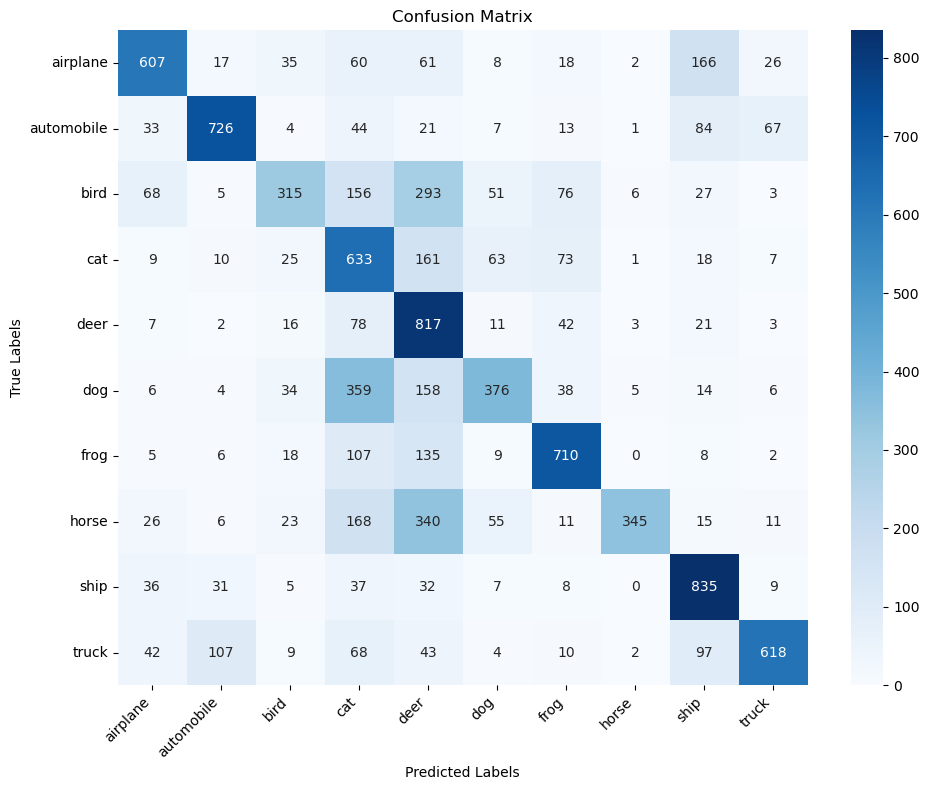

In [7]:
# Metrics

y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = y_test

cm = confusion_matrix(y_true, y_pred, config.NUM_CLASSES)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


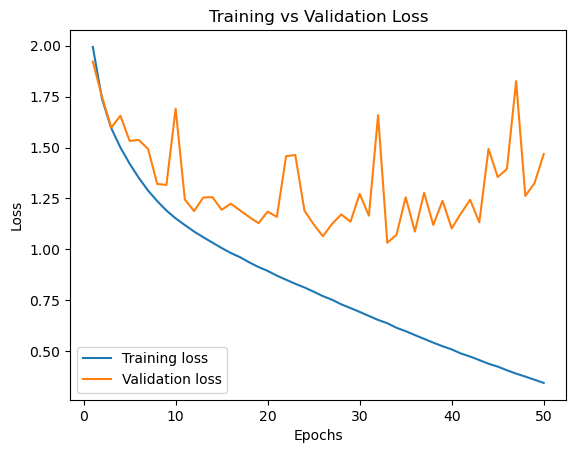

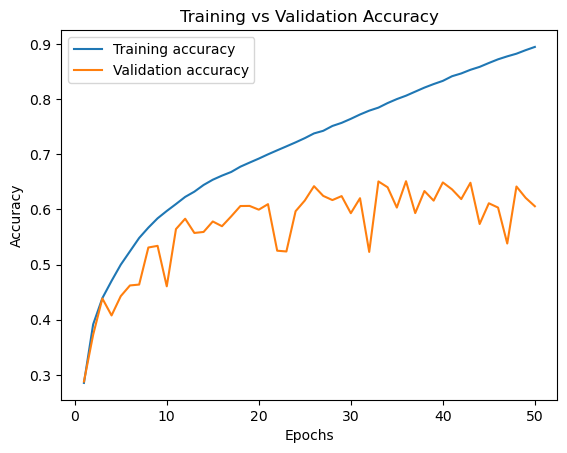

Training Loss: 0.344276
Validation Loss: 1.468210
Training Accuracy: 89.47%
Validation Accuracy: 60.58%


Best Epoch: 33
Best Training Loss: 0.6375
Best Validation Loss: 1.0329
Best Training Accuracy: 78.46%
Best Validation Accuracy: 65.08%


In [8]:
# Plot Training Data
val_loss = history.history['val_loss']
loss = history.history['loss']

# Cleaner and more explicit than hardcoding a range - becomes useful when EarlyStopping comes into play (we pass 'loss' but it could be any history.history.keys() as they all have same length)
epoch_axis = range(1, len(history.history["loss"]) + 1)

plt.figure()
plt.plot(epoch_axis, loss, label="Training loss")
plt.plot(epoch_axis, val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

# storing accuracy metrics
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure()
plt.plot(epoch_axis, accuracy, label="Training accuracy")
plt.plot(epoch_axis, val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()


# print last epoch training data results to snapshot the current model performance [tracked in Excel file]
print(f'Training Loss: {loss[-1]:4f}')
print(f'Validation Loss: {val_loss[-1]:4f}')
print(f'Training Accuracy: {accuracy[-1]:.2%}')
print(f'Validation Accuracy: {val_accuracy[-1]:.2%}')
print('\n')

# Print out the best epoch where val_loss was at a minimum
best_epoch = np.argmin(val_loss)

# Results below are diagnostics only (not used for Excel reporting)
print(f"Best Epoch: {best_epoch + 1}")
print(f"Best Training Loss: {loss[best_epoch]:.4f}")
print(f"Best Validation Loss: {val_loss[best_epoch]:.4f}")
print(f"Best Training Accuracy: {accuracy[best_epoch]:.2%}")
print(f"Best Validation Accuracy: {val_accuracy[best_epoch]:.2%}")
